In [ ]:
# Runtime: choose "Runtime > Change runtime type > GPU" only if you want to run heavy transformer stuff.
!pip install -q nltk scikit-learn pandas matplotlib seaborn joblib imbalanced-learn xgboost sentence-transformers flask-ngrok
# (flask-ngrok provides ngrok wrapper useful in Colab demo; optional)


In [ ]:
!pip install flask-ngrok

In [ ]:
import os
import re
import string
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# imbalance
from imblearn.over_sampling import SMOTE
# advanced embeddings
from sentence_transformers import SentenceTransformer


In [ ]:
import requests
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
import zipfile
import io

response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
with zip_file.open('SMSSpamCollection') as f:
    df = pd.read_csv(f, sep='\t', header=None, names=['label', 'text'])

print(df.shape)
df.head()

(5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
print(df['label'].value_counts())
print()
print("Example spam:")
print(df[df['label']=='spam'].sample(3)['text'].values)
print("\nExample ham:")
print(df[df['label']=='ham'].sample(3)['text'].values)

label
ham     4825
spam     747
Name: count, dtype: int64

Example spam:
['You have 1 new message. Please call 08718738034.'
 'Do you want 750 anytime any network mins 150 text and a NEW VIDEO phone for only five pounds per week call 08002888812 or reply for delivery tomorrow'
 'Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56']

Example ham:
["Ok lor. I'm in town now lei." 'Ok how you dear. Did you call chechi'
 'She is our sister.. She belongs 2 our family.. She is d hope of tomorrow.. Pray 4 her,who was fated 4 d Shoranur train incident. Lets hold our hands together &amp; fuelled by love &amp; concern prior 2 her grief &amp; pain. Pls join in dis chain &amp; pass it. STOP VIOLENCE AGAINST WOMEN.']


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text, remove_stopwords=True, do_lemmatize=True):
    # lower
    text = text.lower()
    # remove urls, emails, numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', ' ', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words and len(t)>1]
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
df['clean_text'] = df['text'].apply(clean_text)
df[['text','clean_text']].sample(6)

,text,clean_text
3203,Okay lor... Wah... like that def they wont let...,okay lor wah like def wont let u go haha say t...
4261,Are you plans with your family set in stone ?,plan family set stone
5302,About &lt;#&gt; bucks. The banks fees are fix...,ltgt buck bank fee fixed better call bank find
3595,Do you want a New Nokia 3510i Colour Phone Del...,want new nokia colour phone delivered tomorrow...
27,Did you catch the bus ? Are you frying an egg ...,catch bus frying egg make tea eating mom left ...
2363,How are you doing? Hope you've settled in for ...,hope youve settled new school year wishin gr day


In [ ]:
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(4457,) (1115,)


              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



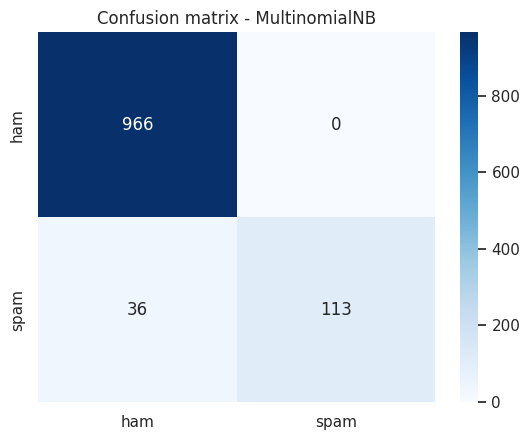

In [ ]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2)),
    ('clf', MultinomialNB())
])

pipe_nb.fit(X_train, y_train)
y_pred = pipe_nb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.title("Confusion matrix - MultinomialNB")
plt.show()


In [ ]:
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga'))
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names=['ham','spam']))


              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       966
        spam       0.90      0.92      0.91       149

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.97      0.98      1115



In [ ]:
params = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__max_df': [0.9, 0.95],
    'clf__C': [0.1, 1, 10]
}
gs = GridSearchCV(pipe_lr, param_grid=params, cv=4, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best = gs.best_estimator_
print(classification_report(y_test, best.predict(X_test), target_names=['ham','spam']))


Fitting 4 folds for each of 12 candidates, totalling 48 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best params: {'clf__C': 0.1, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       966
        spam       0.88      0.89      0.89       149

    accuracy                           0.97      1115
   macro avg       0.93      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
# Save TFIDF + Logistic pipeline
joblib.dump(pipe_lr, "spam_detector_tfidf_logreg.joblib")
# If used embedding model + clf, save clf and vectorizer/embedding model name
# joblib.dump(clf_emb, "spam_detector_emb_logreg.joblib")
# Save TFIDF separately if needed
# joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

['spam_detector_tfidf_logreg.joblib']

In [ ]:
def predict_spam(text, model=pipe_lr):
    text_clean = clean_text(text)
    pred = model.predict([text_clean])[0]
    prob = None
    if hasattr(model, "predict_proba"):
        # Get the probability of the predicted class
        prob_idx = list(model.classes_).index(pred)
        prob = model.predict_proba([text_clean])[0][prob_idx]

    return {'label': pred, 'spam_prob': float(prob) if prob is not None else None}

# Example:
print(predict_spam("Congratulations! You've won a free ticket. Text WIN to 12345"))
print(predict_spam("Can we meet at 5 pm tomorrow?"))

{'label': 'spam', 'spam_prob': 0.9328793044825915}
{'label': 'ham', 'spam_prob': 0.794253682918201}


In [ ]:
!pip install gradio



In [ ]:
import gradio as gr
import joblib
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import os

# Initialize NLTK components after download (assuming previous cell was run)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Load model
# Make sure to run the cell that saves the model before running this cell
try:
    model = joblib.load("spam_detector_tfidf_logreg.joblib")
except FileNotFoundError:
    print("Error: Model file not found. Please run the cell that saves the model ('G1jRR9FrLgyw') first.")
    model = None # Set model to None or handle the error as appropriate


def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t)>1]
    return " ".join(tokens)

def predict_spam(text):
    if model is None:
        return "Model not loaded. Please run the cell that saves the model first."
    text_clean = clean_text(text)
    pred = model.predict([text_clean])[0]
    prob = model.predict_proba([text_clean])[0][list(model.classes_).index('spam')]

    # Color-coded output
    if pred == 'spam':
        return f"🚨 Spam! (Probability: {prob:.2f})"
    else:
        return f"✅ Ham! (Probability: {prob:.2f})"

# Build a modern Gradio UI
with gr.Blocks(theme=gr.themes.Default()) as demo:
    gr.Markdown(
        """
        # 📩 SMS Spam Detector
        **Check whether a message is Spam or Ham.**
        """
    )

    with gr.Row():
        with gr.Column():
            sms_input = gr.Textbox(
                label="Enter SMS Message",
                placeholder="Type your SMS here...",
                lines=6
            )
            submit_btn = gr.Button("Check Message", variant="primary")

        with gr.Column():
            output = gr.Markdown(label="Prediction Result")

    submit_btn.click(fn=predict_spam, inputs=sms_input, outputs=output)

if model is not None:
    demo.launch(share=False)
else:
    print("Gradio demo not launched because the model could not be loaded.")

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import joblib
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Load model
model = joblib.load("spam_detector_tfidf_logreg.joblib")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

def predict_spam(text):
    text_clean = clean_text(text)
    if not text_clean:
        return "❗ Please enter a valid message."

    pred = model.predict([text_clean])[0]
    prob = model.predict_proba([text_clean])[0][list(model.classes_).index('spam')]

    # Output card with colored background
    if pred == 'spam':
        color = "#ff4d4d"  # Red
        emoji = "🚨"
        message = "Spam"
    else:
        color = "#4dff88"  # Green
        emoji = "✅"
        message = "Ham"

    return f"""
    <div style="border-radius:10px; padding:20px; background-color:{color}; color:#000; text-align:center; font-size:18px;">
        <h2>{emoji} {message}</h2>
        <p>Spam Probability: {prob:.2f}</p>
        <div style="background:#fff; border-radius:5px; width:100%; height:15px; margin-top:10px;">
            <div style="background:#000; width:{int(prob*100)}%; height:100%; border-radius:5px;"></div>
        </div>
    </div>
    """

# Gradio UI
with gr.Blocks(theme=gr.themes.Default()) as demo:
    gr.Markdown(
        """
        # 📩 SMS Spam Detector
        Check whether a message is **Spam** or **Ham**.
        """
    )

    with gr.Row():
        with gr.Column():
            sms_input = gr.Textbox(
                label="Enter SMS Message",
                placeholder="Type your SMS here...",
                lines=6
            )
            submit_btn = gr.Button("Check Message", variant="primary")
            gr.Markdown(
                """
                **Example Messages:**
                - "Congratulations! You won a free ticket 🎉"
                - "Hey, are we meeting today?"
                """
            )

        with gr.Column():
            output = gr.HTML(label="Prediction Result")

    submit_btn.click(fn=predict_spam, inputs=sms_input, outputs=output)

demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import joblib
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Load model
model = joblib.load("spam_detector_tfidf_logreg.joblib")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

def predict_spam(text):
    text_clean = clean_text(text)
    if not text_clean:
        return "<p style='color:red;'>❗ Please enter a valid message.</p>"

    pred = model.predict([text_clean])[0]
    prob = model.predict_proba([text_clean])[0][list(model.classes_).index('spam')]

    # Set card style based on prediction
    if pred == 'spam':
        color = "#ff4d4d"
        emoji = "🚨"
        message = "Spam"
    else:
        color = "#4dff88"
        emoji = "✅"
        message = "Ham"

    # Confidence bar width and color
    bar_width = int(prob*100)
    bar_color = "#000000" if pred=="ham" else "#550000"

    # Animated emoji (CSS simple shake for spam)
    emoji_style = "display:inline-block; animation:shake 0.5s infinite;" if pred=="spam" else ""

    return f"""
    <div style="border-radius:15px; padding:25px; background: linear-gradient(135deg, {color}, #ffffff);
                color:#000; text-align:center; font-size:20px; box-shadow: 2px 4px 10px rgba(0,0,0,0.2);">
        <h2 style="font-size:28px;"><span style="{emoji_style}">{emoji}</span> {message}</h2>
        <p style="font-size:18px;">Spam Probability: {prob:.2f}</p>
        <div style="background:#e0e0e0; border-radius:8px; width:80%; height:20px; margin:10px auto;">
            <div style="background:{bar_color}; width:{bar_width}%; height:100%; border-radius:8px;"></div>
        </div>
    </div>

    <style>
    @keyframes shake {{
        0% {{ transform: translate(1px, 1px) rotate(0deg); }}
        25% {{ transform: translate(-1px, 2px) rotate(-1deg); }}
        50% {{ transform: translate(2px, -1px) rotate(1deg); }}
        75% {{ transform: translate(-2px, 1px) rotate(0deg); }}
        100% {{ transform: translate(1px, -1px) rotate(1deg); }}
    }}
    </style>
    """

# Gradio UI with advanced features
with gr.Blocks(theme=gr.themes.Default()) as demo:
    gr.Markdown(
        """
        # 📩 SMS Spam Detector
        Detect whether a message is **Spam** or **Ham** with probability.
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            sms_input = gr.Textbox(
                label="Enter SMS Message",
                placeholder="Type your SMS here...",
                lines=6
            )
            with gr.Row():
                submit_btn = gr.Button("Check Message", variant="primary")
                reset_btn = gr.Button("Reset", variant="secondary")
            gr.Markdown(
                """
                **Example Messages:**
                - "Congratulations! You won a free ticket 🎉"
                - "Hey, are we meeting today?"
                """
            )

        with gr.Column(scale=1):
            output = gr.HTML(label="Prediction Result")

    submit_btn.click(fn=predict_spam, inputs=sms_input, outputs=output)
    reset_btn.click(lambda: "", inputs=None, outputs=[sms_input, output])

demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import joblib
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Load model
model = joblib.load("spam_detector_tfidf_logreg.joblib")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
history = []

SPAM_SOUND_URL = "https://www.soundjay.com/buttons/sounds/beep-07.mp3"

# Example SMS list
example_sms_list = [
    "Congratulations! You won a free ticket 🎉",
    "Hey, are we meeting today?",
    "Free entry in a weekly contest, text WIN to 12345",
    "Call me when you are free",
    "You have won $5000! Claim now",
    "Don't forget the meeting at 10am",
    "Limited offer! Buy 1 get 1 free",
    "Can you send me the report by today?",
    "URGENT! Your account will be suspended",
    "Happy birthday! Have a great day 🎂",
    "Winner! You have been selected for a prize",
    "Let's catch up for coffee",
    "Get cheap loans at 0% interest, apply now",
    "Are you coming to the party tonight?",
    "Exclusive deal just for you, claim now"
]

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

def predict_spam(text):
    global history
    text_clean = clean_text(text)
    if not text_clean:
        return "<p style='color:red;'>❗ Please enter a valid message.</p>", history

    pred = model.predict([text_clean])[0]
    prob = model.predict_proba([text_clean])[0][list(model.classes_).index('spam')]

    if pred == 'spam':
        color = "#ff4d4d"
        emoji = "🚨"
        message = "Spam"
        bar_color = "#550000"
        sound_html = f'<audio autoplay><source src="{SPAM_SOUND_URL}" type="audio/mpeg"></audio>'
        confetti_html = ""
    else:
        color = "#4dff88"
        emoji = "✅"
        message = "Ham"
        bar_color = "#006600"
        sound_html = ""
        confetti_html = '<div class="confetti"></div>' * 30

    bar_width = int(prob*100)
    emoji_style = "display:inline-block; animation:shake 0.5s infinite;" if pred=="spam" else ""

    # Save history
    history_entry = f"{emoji} {message}: {text} (Spam Prob: {prob:.2f})"
    history = [history_entry] + history[:4]

    card_html = f"""
    <div class='output-card'>
        <h2 style="font-size:28px;"><span style="{emoji_style}">{emoji}</span> {message}</h2>
        <p style="font-size:18px;">Spam Probability: {prob:.2f}</p>
        <div style="background:#e0e0e0; border-radius:8px; width:80%; height:20px; margin:10px auto;">
            <div style="background:{bar_color}; width:{bar_width}%; height:100%; border-radius:8px;"></div>
        </div>
        {sound_html}
        {confetti_html}
    </div>

    <style>
    body {{background: linear-gradient(135deg, #f0f8ff, #e6f7ff);}}
    .output-card {{
        border-radius:15px;
        padding:25px;
        background: linear-gradient(135deg, {color}, #ffffff);
        color:#000;
        text-align:center;
        font-size:20px;
        box-shadow: 2px 4px 15px rgba(0,0,0,0.2);
        transition: transform 0.3s, box-shadow 0.3s;
    }}
    .output-card:hover {{
        transform: scale(1.03);
        box-shadow: 4px 8px 20px rgba(0,0,0,0.3);
    }}
    @keyframes shake {{
        0% {{ transform: translate(1px, 1px) rotate(0deg); }}
        25% {{ transform: translate(-1px, 2px) rotate(-1deg); }}
        50% {{ transform: translate(2px, -1px) rotate(1deg); }}
        75% {{ transform: translate(-2px, 1px) rotate(0deg); }}
        100% {{ transform: translate(1px, -1px) rotate(1deg); }}
    }}
    .confetti {{
        width:10px;
        height:10px;
        background-color: #ffcc00;
        position: absolute;
        top: 0;
        left: 50%;
        animation: fall 3s linear infinite;
    }}
    @keyframes fall {{
        0% {{ transform: translateY(0px) rotate(0deg); }}
        100% {{ transform: translateY(200px) rotate(360deg); }}
    }}
    </style>
    """

    history_html = "<h3>📜 Last 5 Predictions:</h3><ul>" + "".join([f"<li>{h}</li>" for h in history]) + "</ul>"

    return card_html + history_html, history

# Gradio UI
with gr.Blocks(theme=gr.themes.Default()) as demo:
    gr.Markdown(
        """
        # 📩 SMS Spam Detector
        Detect whether a message is **Spam** or **Ham** with probability.
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            sms_input = gr.Textbox(label="Enter SMS Message", placeholder="Type your SMS here...", lines=6)
            with gr.Row():
                submit_btn = gr.Button("Check Message", variant="primary")
                reset_btn = gr.Button("Reset", variant="secondary")
            example_dropdown = gr.Dropdown(
                label="Choose Example SMS",
                choices=example_sms_list,
                value=None
            )
        with gr.Column(scale=1):
            output = gr.HTML(label="Prediction Result")

    submit_btn.click(fn=predict_spam, inputs=sms_input, outputs=[output, sms_input])
    reset_btn.click(lambda: ("", []), inputs=None, outputs=[sms_input, output])
    example_dropdown.change(lambda x: x, inputs=example_dropdown, outputs=sms_input)

demo.launch(share=False)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>